In [3]:
# source : https://github.com/keras-team/keras/blob/master/examples/pretrained_word_embeddings.py
'''This script loads pre-trained word embeddings (GloVe embeddings)
into a frozen Keras Embedding layer, and uses it to
train a text classification model on the 20 Newsgroup dataset
(classification of newsgroup messages into 20 different categories).

GloVe embedding data can be found at:
http://nlp.stanford.edu/data/glove.6B.zip
(source page: http://nlp.stanford.edu/projects/glove/)

20 Newsgroup data can be found at:
http://www.cs.cmu.edu/afs/cs.cmu.edu/project/theo-20/www/data/news20.html
'''

from __future__ import print_function

import os
import sys
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.initializers import Constant


BASE_DIR = r'D:\Users\Baptiste\Documents\Telecom_Saint-Etienne\FISE_3\PRI\Classification'
GLOVE_DIR = os.path.join(BASE_DIR, 'glove.6B')
TEXT_DATA_DIR = os.path.join(BASE_DIR, '20_newsgroup')
MAX_SEQUENCE_LENGTH = 1000
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [4]:
# first, build index mapping words in the embeddings set
# to their embedding vector

print('Indexing word vectors.')

embeddings_index = {}
with open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'), encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

# second, prepare text samples and their labels
print('Processing text dataset')

texts = []  # list of text samples
labels_index = {}  # dictionary mapping label name to numeric id
labels = []  # list of label ids
for name in sorted(os.listdir(TEXT_DATA_DIR)):
    path = os.path.join(TEXT_DATA_DIR, name)
    if os.path.isdir(path):
        label_id = len(labels_index)
        labels_index[name] = label_id
        for fname in sorted(os.listdir(path)):
            if fname.isdigit():
                fpath = os.path.join(path, fname)
                args = {} if sys.version_info < (3,) else {'encoding': 'latin-1'}
                with open(fpath, **args) as f:
                    t = f.read()
                    i = t.find('\n\n')  # skip header
                    if 0 < i:
                        t = t[i:]
                    texts.append(t)
                labels.append(label_id)

print('Found %s texts.' % len(texts))

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

print('Preparing embedding matrix.')

# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

print('Create training model.')

# train a 1D convnet with global maxpooling
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(len(labels_index), activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

Indexing word vectors.
Found 400000 word vectors.
Processing text dataset
Found 19997 texts.
Found 174074 unique tokens.
Shape of data tensor: (19997, 1000)
Shape of label tensor: (19997, 20)
Preparing embedding matrix.
Create training model.


In [8]:
import matplotlib.pyplot as plt

print('Training model')

history = model.fit(x_train, y_train,
          batch_size=128,
          epochs=10,
          validation_data=(x_val, y_val))

Training model
Train on 15998 samples, validate on 3999 samples
Epoch 1/10
15998/15998 [==============================] - 13s 828us/step - loss: 2.4532 - acc: 0.2025 - val_loss: 1.9457 - val_acc: 0.2951
Epoch 2/10
15998/15998 [==============================] - 8s 473us/step - loss: 1.5657 - acc: 0.4509 - val_loss: 1.4073 - val_acc: 0.5051
Epoch 3/10
15998/15998 [==============================] - 8s 473us/step - loss: 1.1819 - acc: 0.5898 - val_loss: 1.2889 - val_acc: 0.5569
Epoch 4/10
15998/15998 [==============================] - 8s 474us/step - loss: 0.9639 - acc: 0.6705 - val_loss: 1.1117 - val_acc: 0.6164
Epoch 5/10
15998/15998 [==============================] - 8s 473us/step - loss: 0.8145 - acc: 0.7258 - val_loss: 0.9557 - val_acc: 0.6752
Epoch 6/10
15998/15998 [==============================] - 8s 472us/step - loss: 0.6928 - acc: 0.7660 - val_loss: 1.0049 - val_acc: 0.6727
Epoch 7/10
15998/15998 [==============================] - 8s 473us/step - loss: 0.5885 - acc: 0.8002 - val_

plot model


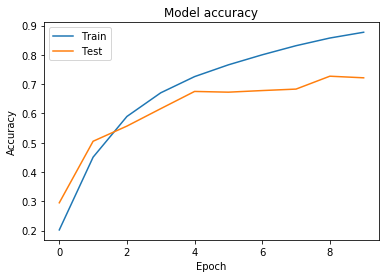

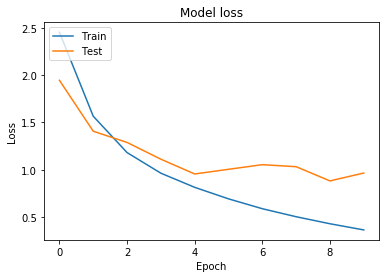

In [9]:
print('plot model')

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [12]:
# https://www.opencodez.com/python/text-classification-using-keras.htm
# Below code saves the model as well as tokenizer. We have to save our tokenizer because it is our vocabulary.
# The same tokenizer and vocabulary have to be used for accurate prediction.

# creates a HDF5 file
model.save('model.h5')

In [13]:
from keras.models import load_model

# load our saved model
model = load_model('model.h5')